In [1]:
import sys
 
# setting path
sys.path.append('..')

import pandas as pd
import mne
import numpy as np
import autoreject
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import sklearn

from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials

from mne.parallel import parallel_func
from mne_features.univariate import compute_hjorth_mobility,compute_pow_freq_bands
from mne.preprocessing import corrmap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns

## 1. Read a RN App, converted pkl file, and create the metadata and data structure

In [2]:
from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle

In [3]:
data_dir = "../data/"
lsl_dir = "../mna/LSLPresets/"
output_dir = '../output/'

if not os.path.isdir(output_dir): os.makedirs(output_dir)
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]

# all_dfs = pd.read_excel("output/all_results_cleaned.xlsx")
# all_dfs = clean_up_adadrive_trials(all_dfs)

save_data_pkl = False # save data into pickle files
save_ica_plts = False # save ICA components plots
epoch_raw_eeg = False # epoching raw data
motor_events = False
rs = 64 # random seed

Creating RawArray with float64 data, n_channels=89, n_times=3399947
    Range : 0 ... 3399946 =      0.000 ...  1660.130 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.0s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj20ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj20ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 35.2s.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
40 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 411 original time points ...
0 bad epochs dropped
Dropped 1 epoch: 25
Not setting metadata
40 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 411 original 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.7s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj14ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj14ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 34.0s.
Median correlation with constructed map: 0.984
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.989
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
34 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 411 original time points ...
0 bad epochs droppe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.3s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj12ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj12ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 25.0s.
Median correlation with constructed map: 0.995
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.994
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
34 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 411 original time points ...
0 bad epochs droppe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.3s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj12ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj12ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 30.4s.
Median correlation with constructed map: 0.993
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
23 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 411 original time points ...
0 bad epochs droppe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.6s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj22ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj22ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 40.4s.
Median correlation with constructed map: 0.983
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
5 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 411 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    5.8s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj16ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj16ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 23.8s.
Median correlation with constructed map: 0.986
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.994
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
49 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 49 events and 411 original time points ...
1 bad epochs droppe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   12.2s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj18ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj18ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 33.8s.
Median correlation with constructed map: 0.995
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.989
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
31 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 411 original time points ...
0 bad epochs droppe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   10.0s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj19ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj19ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 426.1s.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.995
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
Not setting metadata
32 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 411 original time points ...
0 bad epochs dropp

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   10.2s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj12ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj12ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 38.1s.
Median correlation with constructed map: 0.992
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
49 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 49 events and 411 original time points ...
0 bad epochs droppe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.8s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj16ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj16ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 33.1s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.993
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Not setting metadata
38 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 411 original time poi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.2s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj21ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj21ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 38.0s.
Median correlation with constructed map: 0.975
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
38 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 411 original time points ...
0 bad epochs droppe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.4s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj19ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj19ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 35.2s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
14 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 14 eve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.2s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj21ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj21ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 33.0s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
26 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 26 eve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.1s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj15ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj15ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 53.3s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
21 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 eve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.4s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj14ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj14ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 30.1s.
Median correlation with constructed map: 0.988
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.984
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
16 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 16 events and 411 original time points ...
0 bad epochs droppe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.4s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj16ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj16ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 32.4s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
39 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 eve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.6s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj19ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj19ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 56.5s.
Median correlation with constructed map: 0.990
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.979
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
Not setting metadata
32 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 411 original time points ...
0 bad epochs droppe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.0s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj13ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj13ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 27.3s.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Not setting metadata
44 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 44 events and 411 original time poi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.3s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj20ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj20ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 22.6s.
Median correlation with constructed map: 0.992
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.986
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
31 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 411 original time points ...
1 bad epochs droppe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.6s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj18ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj18ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 24.7s.
Median correlation with constructed map: 0.990
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Not setting metadata
22 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 22 events and 411 original time poi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.6s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj23ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj23ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 32.1s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
19 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 19 eve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.2s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj21ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj21ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 45.0s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Not setting metadata
39 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 411 original time poi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.3s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj13ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj13ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 27.6s.
Median correlation with constructed map: 0.988
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Not setting metadata
30 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 411 original time poi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.0s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj17ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj17ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 26.5s.
Median correlation with constructed map: 0.995
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.990
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
35 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 411 original time points ...
1 bad epochs droppe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.4s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj20ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj20ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 24.3s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
20 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 eve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.5s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj14ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj14ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 31.8s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
33 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 eve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   10.2s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj13ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj13ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 207.1s.
Median correlation with constructed map: 0.985
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
Not setting metadata
12 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 411 original time points ...
0 bad epochs dropp

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.7s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj18ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj18ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 40.6s.
Median correlation with constructed map: 0.985
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Not setting metadata
25 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 411 original time poi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   10.9s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj17ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj17ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 31.7s.
Median correlation with constructed map: 0.999
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.986
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
23 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 411 original time points ...
0 bad epochs droppe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.0s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj23ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj23ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 30.5s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
39 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 eve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.8s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj23ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj23ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 39.8s.
Median correlation with constructed map: 0.983
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.990
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
45 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 45 events and 411 original time points ...
1 bad epochs droppe

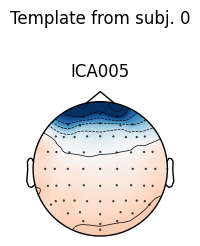

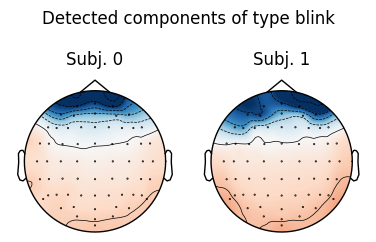

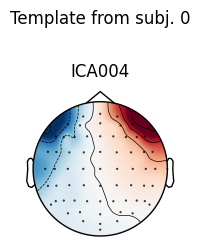

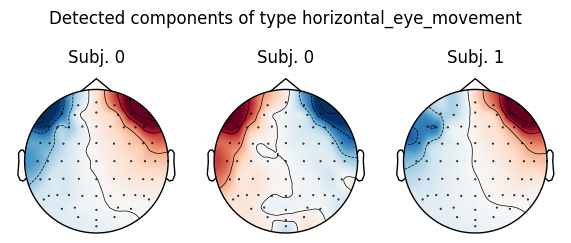

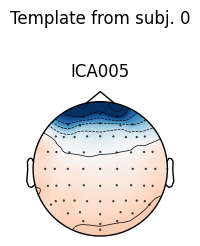

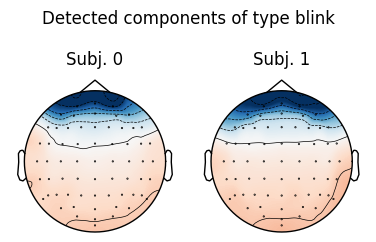

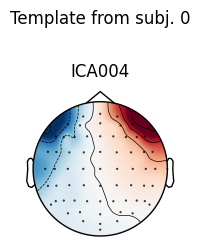

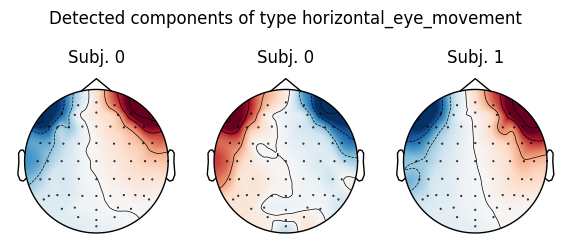

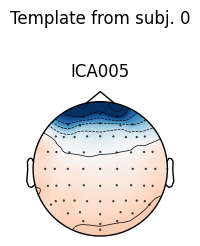

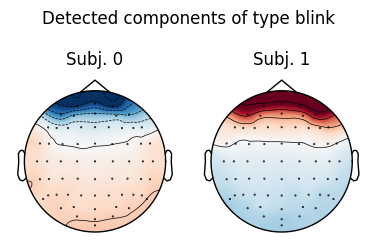

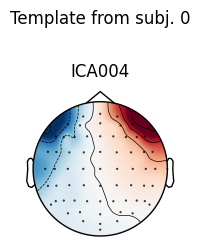

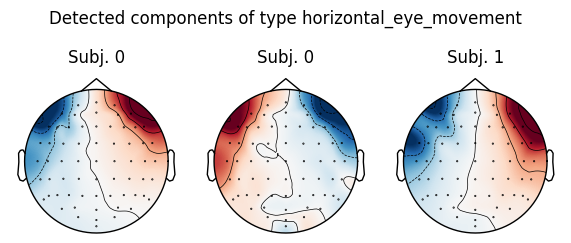

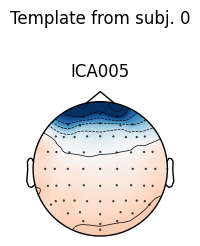

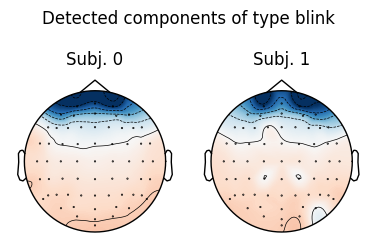

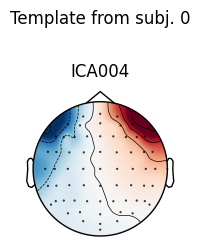

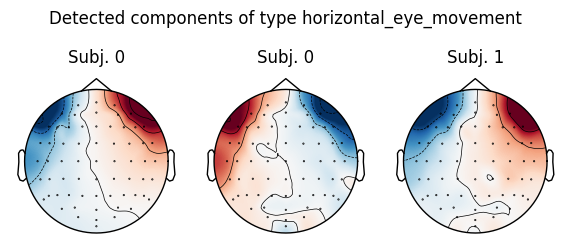

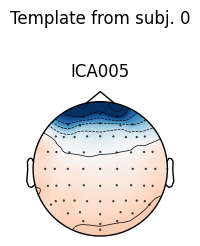

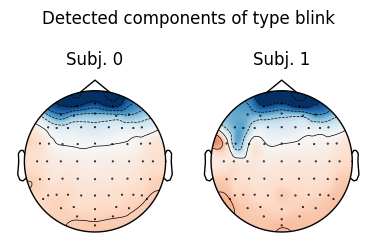

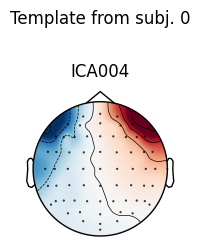

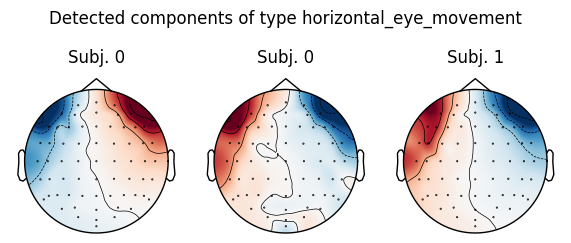

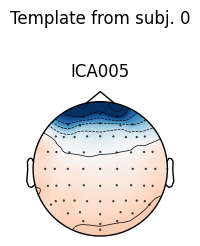

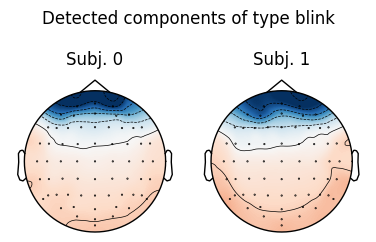

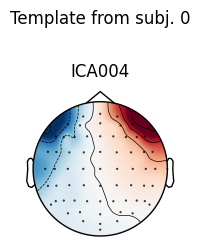

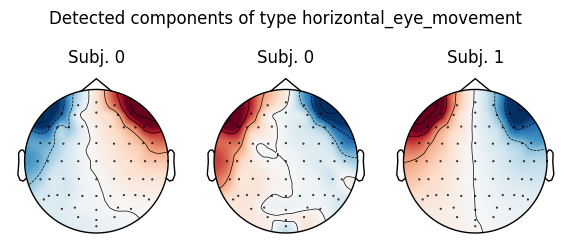

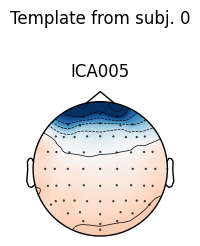

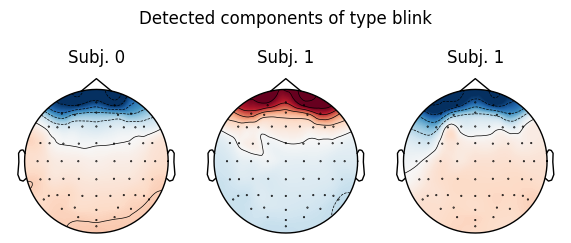

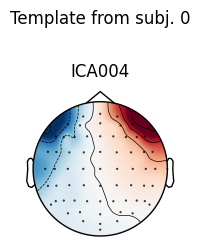

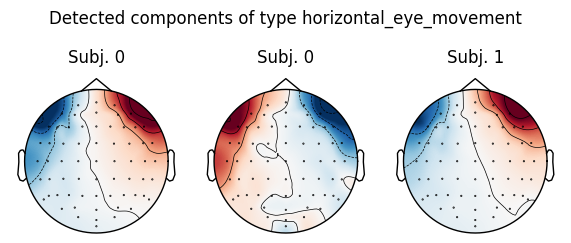

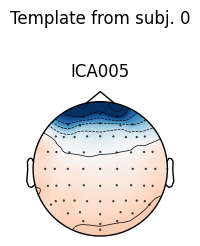

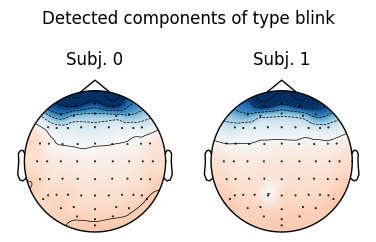

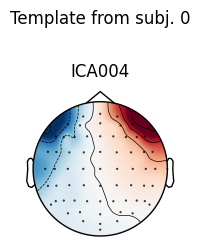

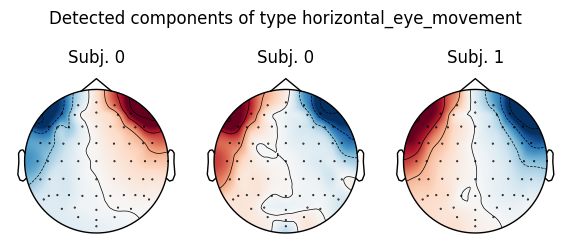

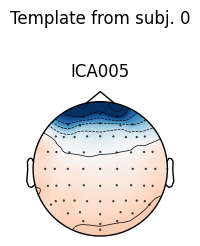

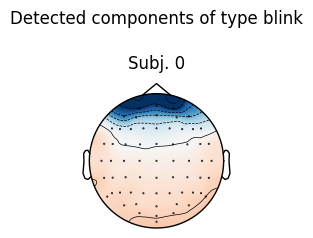

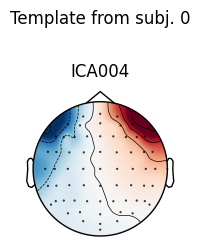

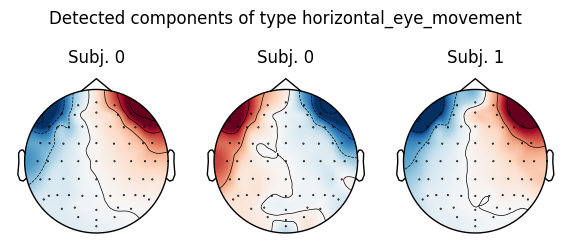

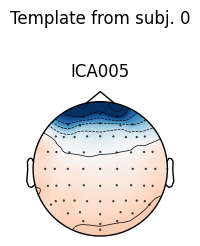

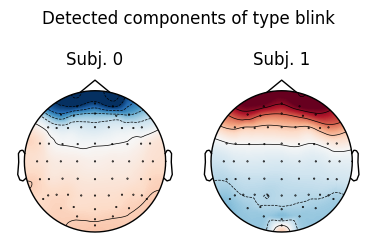

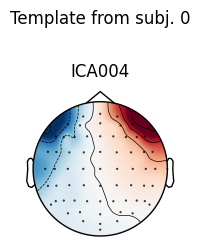

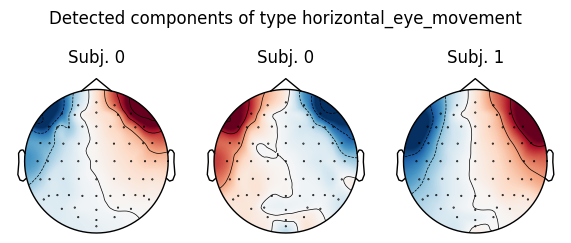

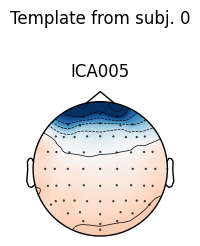

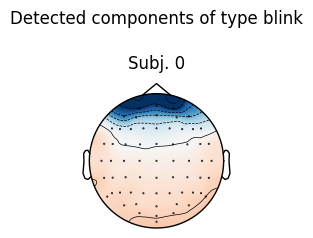

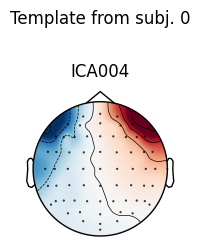

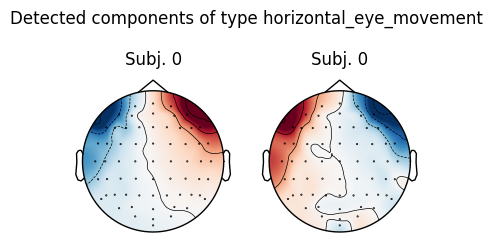

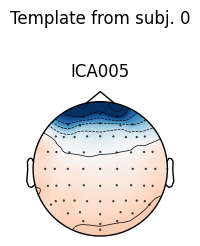

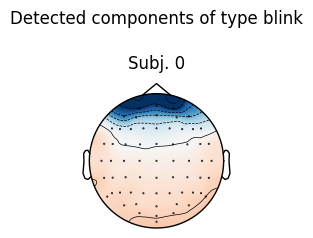

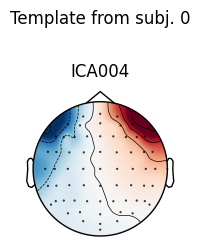

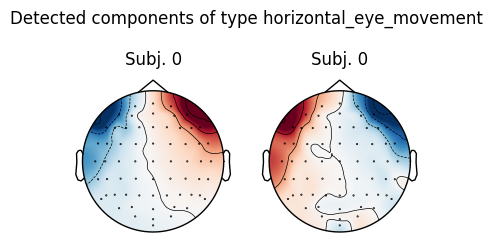

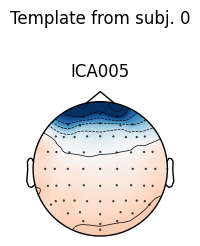

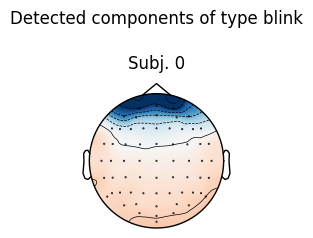

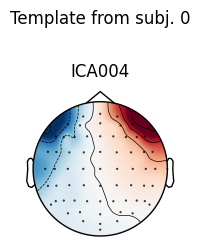

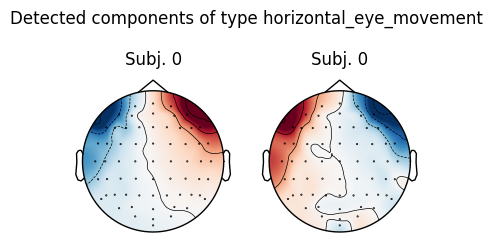

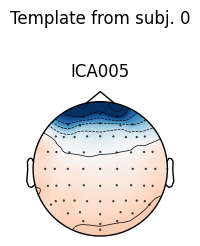

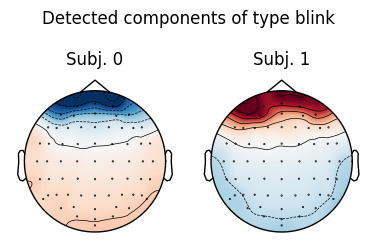

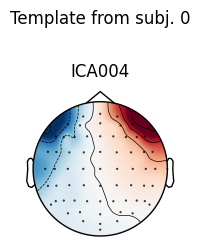

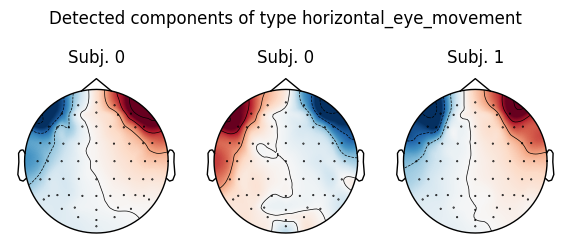

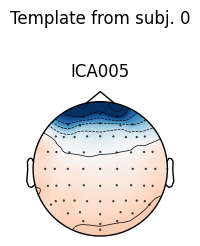

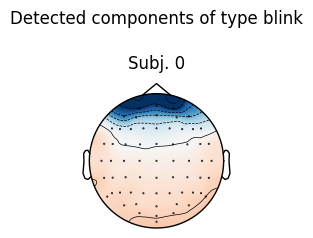

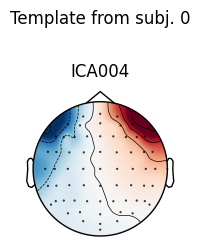

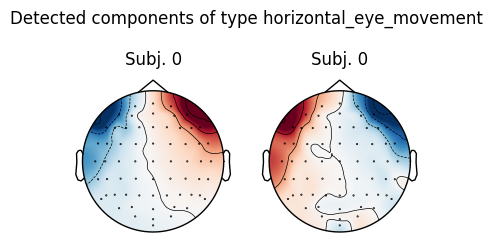

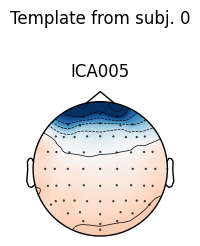

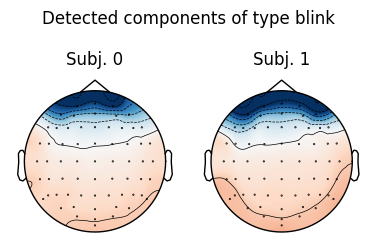

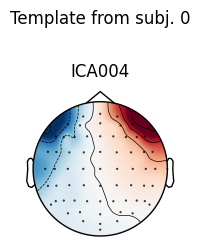

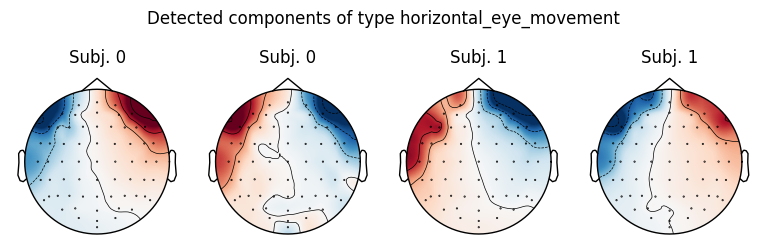

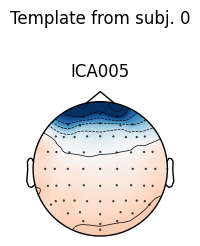

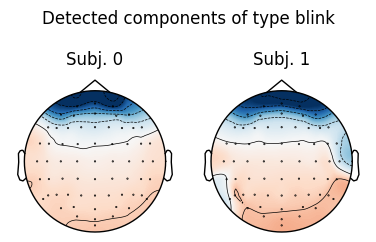

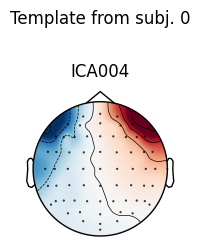

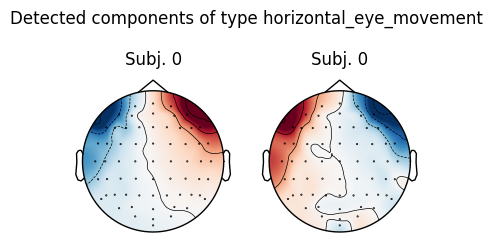

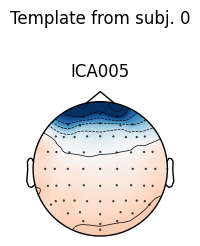

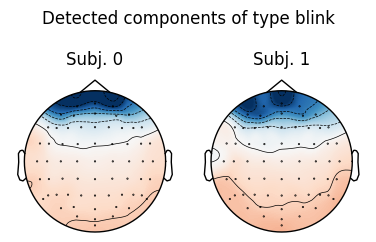

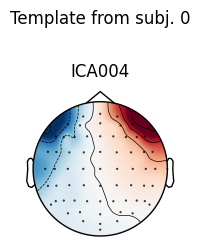

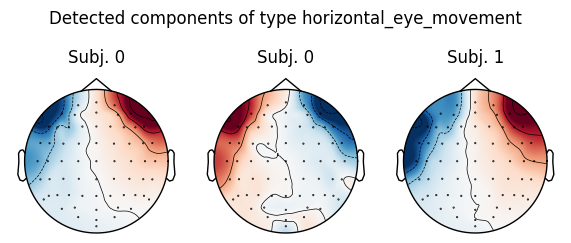

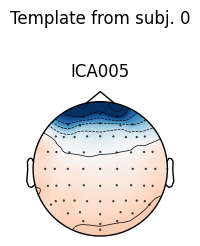

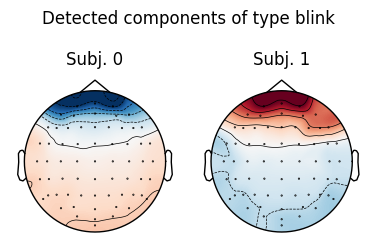

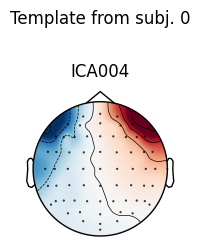

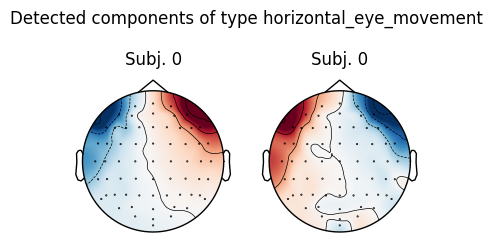

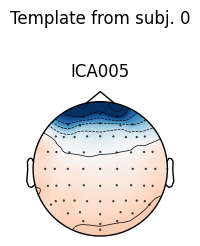

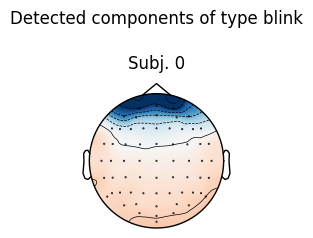

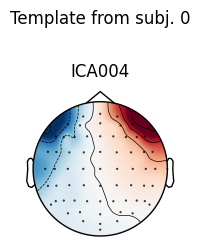

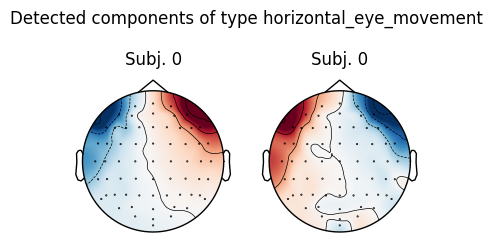

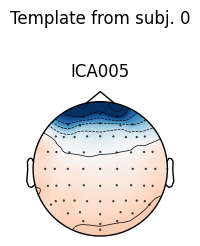

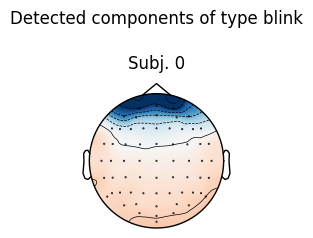

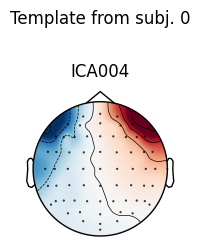

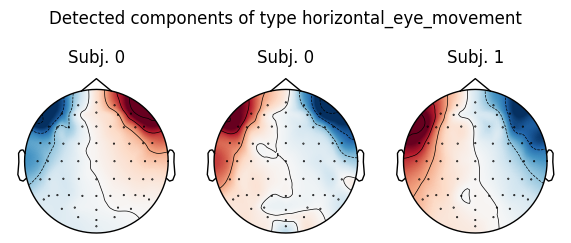

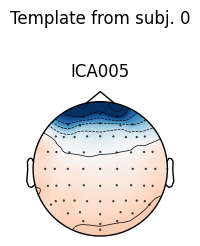

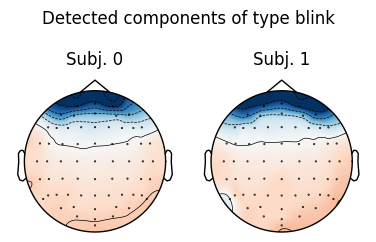

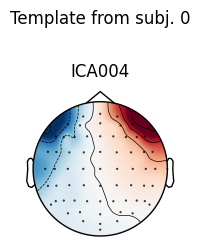

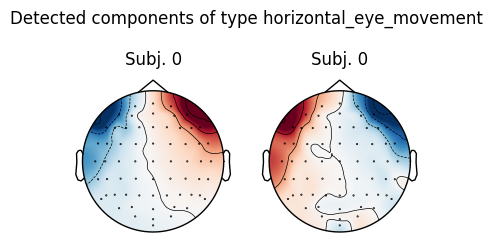

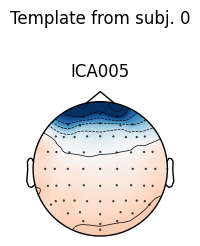

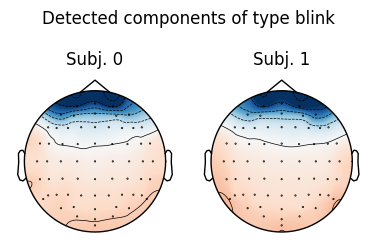

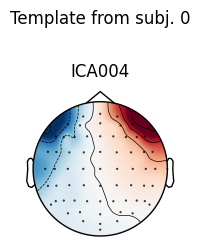

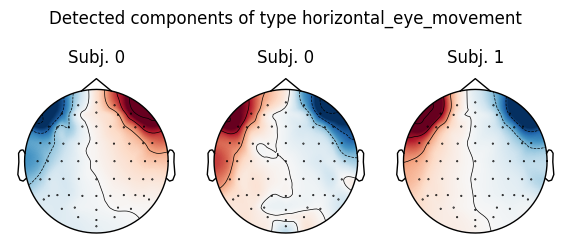

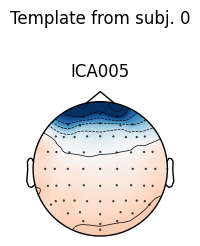

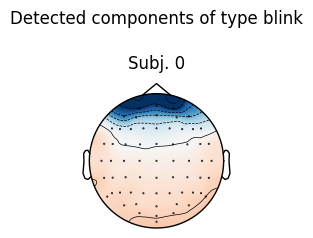

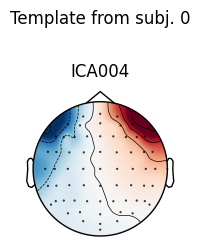

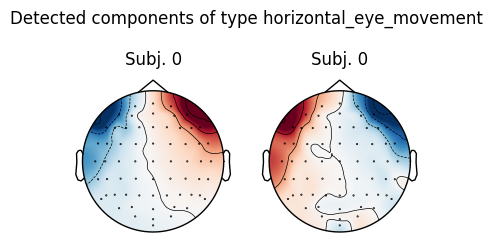

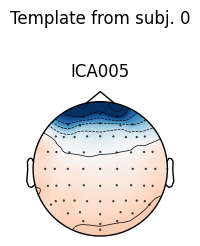

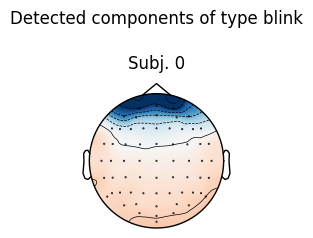

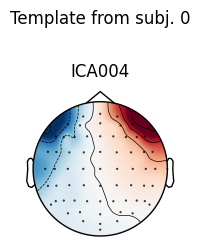

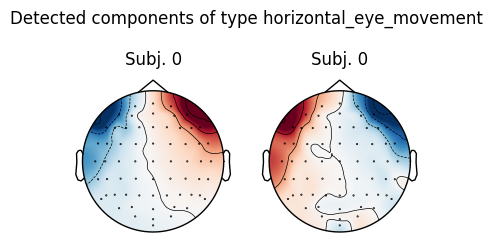

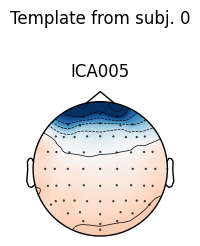

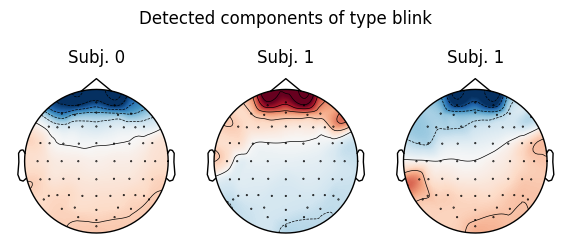

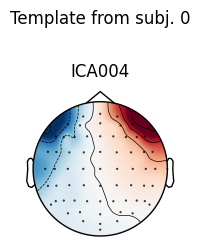

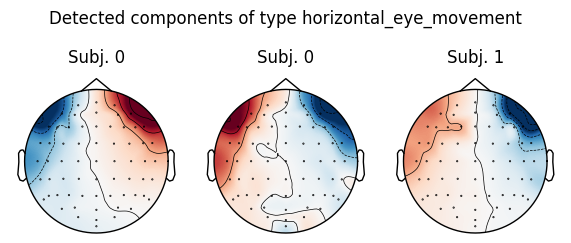

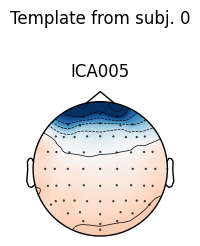

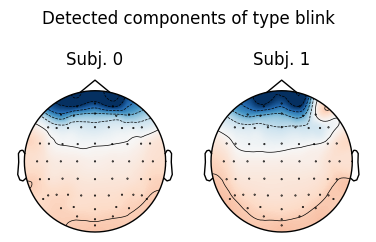

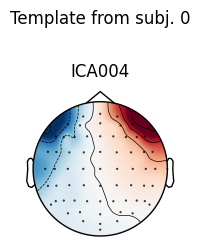

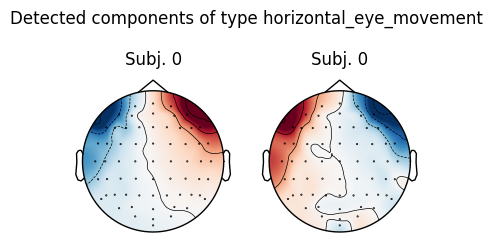

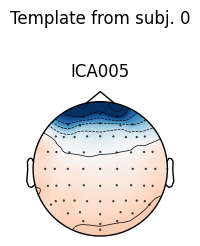

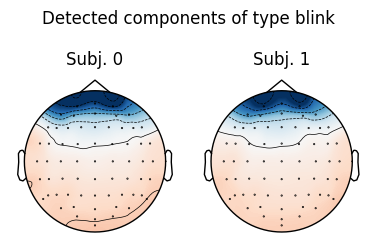

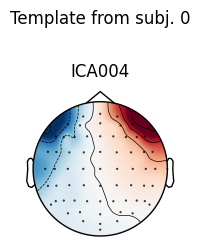

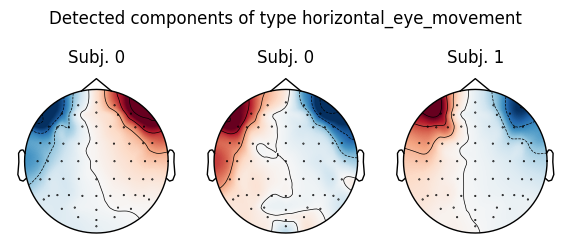

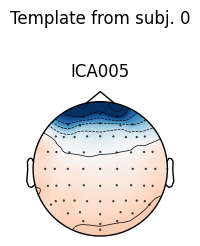

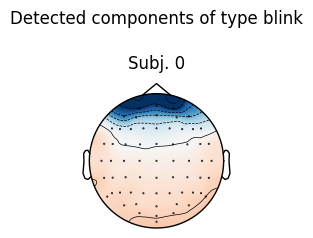

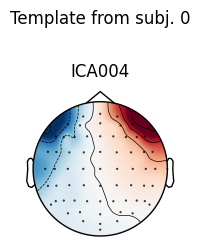

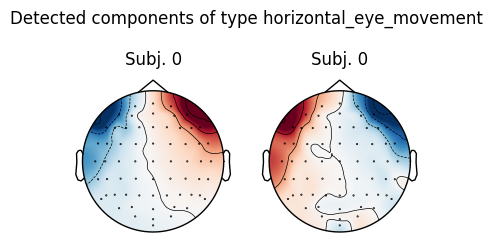

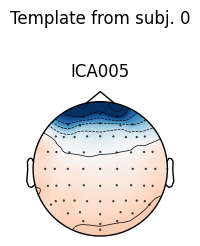

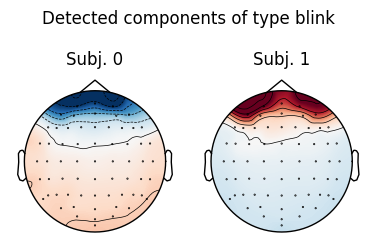

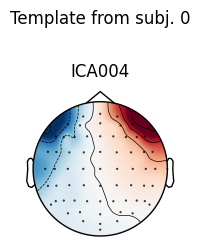

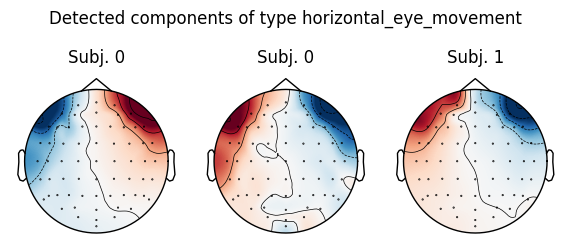

In [4]:
all_dfs = None

ica_epochs_dict = {}
ica_dict = {}
eog_idx_dict = {}
events_dict = {}

for each_file in onlyfiles:
    input_path = data_dir + each_file
    
    sbj_id = each_file[each_file.find('Sbj_')+4:each_file.find('-Ssn')]
    ssn_no = each_file[each_file.find('Ssn_')+4:each_file.find('.dats')]

    if len(sbj_id) < 2: sbj = "sbj0"+sbj_id
    else: sbj = "sbj"+sbj_id
    if len(ssn_no) < 2: ssn = "ssn0"+ssn_no
    else: ssn = "ssn"+ssn_no
    
    if sbj+ssn == "sbj20ssn03":
        ref_ica = None
    else: 
        ref_ica = ica_dict['sbj20ssn03']
    
    with open(input_path, 'rb') as handle:
        rns_data = pickle.load(handle)

    ## Add metadata to data

    for key in rns_data.keys():
        rns_data[key].append(return_metadata_from_name(key, metadata_jsons))

    event_df = event_data_from_data(rns_data, interrupted_id_sessions=[(13,1), (22,1)])
    event_df['trial_damage'] = event_df.damage.diff().fillna(0)
    event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time

    percent_missing = event_df.notnull().sum() / len(event_df)
    summary_statistics = {}
    summary_statistics['voice_success_rate'] = percent_missing['voice_timestamp']
    if 'chunk_timestamp' in percent_missing:
        summary_statistics['chunk_success_rate'] = percent_missing['chunk_timestamp']
    else:
        summary_statistics['chunk_success_rate'] = 0

    # temporary fix for pilot phase where we had some incomplete data
    if 'block_condition' not in event_df:
        event_df['block_condition'] = 'practice'
        event_df.loc[5:,'block_condition'] = 'voice'

    event_df['spoken_difficulty_encoded'] = event_df.spoken_difficulty.replace(to_replace=['easy', 'hard', 'unknown'],
                                                                          value=[1, 2, None])

    # ecg
    post_processed_event_df = process_session_ecg(rns_data, event_df,plot_frequency=20,plot_ecg_snippet=40)

    # eye
    # post_processed_event_df = process_session_eye(rns_data, post_processed_event_df,detect_blink=True,pretrial_period=0,
    #                                               posttrial_period=0,plot_frequency=20, plot_eye_snippet=40, classifiers=['NSLR'])
    if 'Unity_ViveSREyeTracking' in rns_data:
        post_processed_event_df = process_session_eye(rns_data, post_processed_event_df,detect_blink=True,
                                                      pretrial_period=0, posttrial_period=0, plot_frequency=20, 
                                                      plot_eye_snippet=40, classifiers=['NSLR'])

    # eeg
    post_processed_event_df, epochs, events, info, reject_log, ica, eog_idx= process_session_eeg(rns_data, post_processed_event_df,
                                run_autoreject=True, run_ica=True, save_raw_eeg = True, sbj_session = sbj+ssn, 
                                template_ica = ref_ica, analyze_pre_ica = True)
    
    # # motor
    # post_processed_event_df, turns_df = process_session_motor(rns_data, event_df, motor_channel='Unity_MotorInput',
    #                                             plot_motor_result = True, plot_motor_snippet = 30, plot_frequency = 10)
    # if motor_events:
    #     post_processed_event_df = turns_df
    
    events_dict[sbj+ssn] = events
    ica_epochs_dict[sbj+ssn] = epochs
    ica_dict[sbj+ssn] = ica
    eog_idx_dict[sbj+ssn] = eog_idx
    
    # save data for later use
    if save_data_pkl:
        
        with open('../output/saved_files/pickle_files/all_events.pickle', 'wb') as handle_events:
            pickle.dump(events_dict, handle_events, protocol=pickle.HIGHEST_PROTOCOL)
        with open('../output/saved_files/pickle_files/ica_epochs.pickle', 'wb') as handle_ica_eps:
            pickle.dump(ica_epochs_dict, handle_ica_eps, protocol=pickle.HIGHEST_PROTOCOL)
        with open('../output/saved_files/pickle_files/ica.pickle', 'wb') as handle_ica:
            pickle.dump(ica_dict, handle_ica, protocol=pickle.HIGHEST_PROTOCOL)
        with open('../output/saved_files/pickle_files/eog_comp.pickle', 'wb') as handle_eog:
            pickle.dump(eog_idx_dict, handle_eog, protocol=pickle.HIGHEST_PROTOCOL)

    # save
    post_processed_event_df.to_csv(f"{output_dir}ppid_{post_processed_event_df.iloc[0].ppid}_session_{post_processed_event_df.iloc[0].session}.csv")
    if not type(all_dfs)==pd.core.frame.DataFrame:
        all_dfs = post_processed_event_df
    else:
        all_dfs = pd.concat([all_dfs, post_processed_event_df], ignore_index=True)
    

In [4]:
# from pivottablejs import pivot_ui
all_dfs.to_csv(f"../output/saved_files/all_results.csv")
# all_dfs.to_excel(f"{output_dir}all_results.xlsx")
# pivot_ui(all_dfs, outfile_path=f"{output_dir}all_results.html");

NameError: name 'all_dfs' is not defined

## 2. Load Data and Feature Extraction

In [62]:
# load raw eeg.fif file and epoch raw eeg

if epoch_raw_eeg:

    with open('../output/saved_files/pickle_files/all_events.pickle', 'rb') as handle:
        all_events = pickle.load(handle)

    raw_eeg_dir = '../output/saved_files/raw_eeg/'
    event_dict = dict(easy=1, hard=2)

    raw_eeg_dict = {}
    raw_epochs_dict = {}

    for sbj_ssn in list(all_events.keys()):

        each_raw_eeg = sbj_ssn + '_eeg_filt_raw.fif'
        raw_eeg_path = raw_eeg_dir+each_raw_eeg
        raw_eeg = mne.io.read_raw_fif(raw_eeg_path, preload=True)
        raw_eeg_dict[sbj_ssn] = raw_eeg

        epochs_raw = mne.Epochs(raw_eeg, all_events[sbj_ssn], event_id=event_dict, baseline = (None, 0), tmin= -.2, tmax=3, preload=True, on_missing='warn')

        autoreject_epochs = 20
        run_autoreject = True

        if len(epochs_raw) < 10: # we need at least 10 epochs to run autoreject for cross validation
            # bad_epochs_raw = pd.Series(np.full(len(event_df),np.NAN), index=event_df.index, name='autorejected')
            # event_df = event_df.join(bad_epochs)
            reject_log = None
        elif run_autoreject:
            ar_raw = autoreject.AutoReject(random_state=11,n_jobs=1, verbose=False)
            ar_raw.fit(epochs_raw[:autoreject_epochs])  # fit on a few epochs to save time
            epochs_ar, reject_log = ar_raw.transform(epochs_raw, return_log=True)
            # bad_epochs = pd.Series(reject_log.bad_epochs, index=event_recognized_df.index, dtype=bool, name='autorejected')
            # event_df = event_df.join(bad_epochs_raw) # creates nan if not processed at all
            epochs_raw = epochs_ar

        raw_epochs_dict[sbj_ssn] = epochs_raw

    with open('../output/saved_files/pickle_files/raw_epochs.pickle', 'wb') as handle_raw_eps:
        pickle.dump(raw_epochs_dict, handle_raw_eps, protocol=pickle.HIGHEST_PROTOCOL)
    with open('../output/saved_files/pickle_files/raw_eeg.pickle', 'wb') as handle_raw_eeg:
        pickle.dump(raw_eeg_dict, handle_raw_eeg, protocol=pickle.HIGHEST_PROTOCOL)


Opening raw data file ../output/saved_files/raw_eeg/sbj20ssn03_eeg_filt_raw.fif...
    Range : 0 ... 212496 =      0.000 ...  1660.125 secs
Ready.
Reading 0 ... 212496  =      0.000 ...  1660.125 secs...
Not setting metadata
40 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 411 original time points ...
0 bad epochs dropped
Dropped 23 epochs: 1, 5, 9, 10, 11, 13, 17, 18, 19, 22, 23, 25, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 39
Opening raw data file ../output/saved_files/raw_eeg/sbj14ssn03_eeg_filt_raw.fif...
    Range : 0 ... 180126 =      0.000 ...  1407.234 secs
Ready.
Reading 0 ... 180126  =      0.000 ...  1407.234 secs...
Not setting metadata
34 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 411 o

In [4]:
all_dfs = pd.read_csv("../output/saved_files/all_results.csv")

# open saved pickle files
with open('../output/saved_files/pickle_files/ica_epochs.pickle', 'rb') as handle:
    all_proc_epochs = pickle.load(handle)
with open('../output/saved_files/pickle_files/ica.pickle', 'rb') as handle:
    all_ica = pickle.load(handle)
with open('../output/saved_files/pickle_files/eog_comp.pickle', 'rb') as handle:
    all_eog_comps = pickle.load(handle)
with open('../output/saved_files/pickle_files/raw_epochs.pickle', 'rb') as handle:
    all_raw_epochs = pickle.load(handle)

# save ICA components plot
if save_ica_plts:
    ica_comp_dir = "../output/plots/ica_comps/"
    if not os.path.isdir(ica_comp_dir): os.makedirs(ica_comp_dir)

    for sbj_ssn in list(all_ica.keys()):
        
        all_ica[sbj_ssn].plot_components(picks = list(range(0,20)), title=sbj_ssn+"_ICA_Components", show=False)

        plt.savefig(f"{ica_comp_dir}{sbj_ssn}_ica_comps.png")
        plt.close()

In [5]:
# Removed component for all sessions

show_removed_comp = False

if show_removed_comp:
    for sbj in all_ica.keys():
        if all_eog_comps[sbj] != []:

            all_ica[sbj].plot_components(picks = all_eog_comps[sbj], title=sbj, show=False)

            plt.savefig(f"../output/plots/Removed_Components_Corrmap/{sbj}_removed_components.png")
            plt.close()
        else:
            pass
    
# all_eog_comps.values()

In [6]:
# Concatenating all epochs
raw_epochs_concat = mne.concatenate_epochs(list(all_raw_epochs.values()))
proc_epochs_concat = mne.concatenate_epochs(list(all_proc_epochs.values()))

# get EEG data and labels from concatenated epoch objects
raw_epochs_eeg = raw_epochs_concat.get_data()
proc_epochs_eeg = proc_epochs_concat.get_data()

raw_labels = raw_epochs_concat.events[:,2]
proc_labels = proc_epochs_concat.events[:,2]

Not setting metadata
759 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
848 matching events found
Applying baseline correction (mode: mean)


In [7]:
proc_epochs_concat

<Epochs |  848 events (all good), -0.203125 - 3 sec, baseline -0.203125 – 0 sec, ~170.3 MB, data loaded,
 'easy': 470
 'hard': 378>

### EEG Feature Extraction

In [8]:
all_dfs_cleaned_up = all_dfs.copy()
all_dfs_cleaned_up = clean_up_adadrive_trials(all_dfs_cleaned_up)

In [ ]:
# new classification label based on wheel input

wheel_input_metric = all_dfs_cleaned_up['abs_sum_delta_throttle_input']/all_dfs_cleaned_up['abs_sum_delta_brake_input']

driving_metric = pd.qcut(wheel_input_metric, 2, labels=["High", "Low"])
driving_metric_df = pd.DataFrame(driving_metric,columns = ['driving_metric'])
all_dfs_cleaned_up = all_dfs_cleaned_up.join(driving_metric_df)

all_dfs_cleaned_up = all_dfs_cleaned_up.replace({'driving_metric':{'High': 2, 'Low': 1}})

In [9]:
def eeg_features(all_data, data_type):
    
    if data_type == 'processed':
        first_electrode_column_name = "Fp1_4-8_Hz_Power"
        last_electrode_column_name = "O2_32-55_Hz_Sample_entropy"
        autoreject_column_name = "autorejected"
    elif data_type == 'raw':
        first_electrode_column_name = "Fp1_4-8_Hz_Power_raw"
        last_electrode_column_name = "O2_32-55_Hz_Sample_entropy_raw"
        autoreject_column_name = "autorejected_raw"
        
    first_electrode_idx = all_data.columns.get_loc(first_electrode_column_name)
    last_electrode_idx = all_data.columns.get_loc(last_electrode_column_name)

    left_pupil_diameter_idx = all_data.columns.get_loc("Left Pupil Diameter")
    right_pupil_diameter_idx = all_data.columns.get_loc("Right Pupil Diameter")

    # with autoreject
    valid_trial = (all_data['spoken_difficulty_encoded'].notnull()) & (all_data[autoreject_column_name] == False)
    
    all_eeg_features = all_data.iloc[:,first_electrode_idx:last_electrode_idx+1] # all freq band power in cleaned up data
    pupil_diameter = all_data.iloc[:,left_pupil_diameter_idx:right_pupil_diameter_idx+1]

    data_features = np.asarray(all_eeg_features.join(pupil_diameter)[valid_trial])
    data_labels = np.asarray(all_data[valid_trial]['spoken_difficulty_encoded'])

    # select only particular channel AF4, F6, F4, AF8, AF7, AF3, F5, F3, FC2, FC4,FC1, FC3, PO4, P4, P6, P3,P5, PO3
    selected_channel_eeg_features = all_eeg_features.loc[:,
                            all_eeg_features.columns.str.contains('AF4|F6|F4|AF8|AF3|F5|F3|AF7|FC2|FC4|FC4|FC1|FC3|PO4|P4|P6|P3|P5|PO3')]
    selected_data_features=np.asarray(selected_channel_eeg_features.join(pupil_diameter)[valid_trial])
    selected_data_labels=np.asarray(all_dfs_cleaned_up[valid_trial]['spoken_difficulty_encoded'])
    
    # without autoreject
    # valid_trial = all_data['spoken_difficulty_encoded'].notnull()
    # data_labels = np.asarray(all_data[valid_trial]['driving_metric'])
    # selected_data_labels=np.asarray(all_dfs_cleaned_up[valid_trial]['driving_metric'])
    
    return all_eeg_features,data_features, data_labels
    # return selected_channel_eeg_features,selected_data_features, selected_data_labels

In [10]:
# raw_selected_channel_bp, raw_selected_data_features, raw_selected_data_labels = eeg_features(all_dfs_cleaned_up, 'raw')
# processed_selected_channel_bp, processed_selected_data_features, processed_selected_data_labels = eeg_features(all_dfs_cleaned_up, 'processed')

raw_eeg_features, raw_data_features, raw_labels = eeg_features(all_dfs_cleaned_up, 'raw')
processed_eeg_features, processed_data_features, processed_labels = eeg_features(all_dfs_cleaned_up, 'processed')

### Features Concatenation and Normalization

In [11]:
# raw_feature = raw_selected_data_features
# proc_feature = processed_selected_data_features

raw_feature = raw_data_features
proc_feature = processed_data_features

if sum(sum(np.isnan(raw_feature))) > 0 or sum(sum(np.isnan(proc_feature))) > 0:
    
    invalid_pupil_proc = np.argwhere(np.any(np.isnan(proc_feature) == True, axis=1))
    proc_feature_corrected = np.delete(proc_feature, invalid_pupil_proc, axis=0)
    proc_labels_corrected = np.delete(processed_labels, invalid_pupil_proc, axis=0)
    
    invalid_pupil_raw = np.argwhere(np.any(np.isnan(raw_feature) == True, axis=1))
    raw_feature_corrected = np.delete(raw_feature, invalid_pupil_raw, axis=0)
    raw_labels_corrected = np.delete(raw_labels, invalid_pupil_raw, axis=0)
    
else:
    raw_feature_corrected = raw_feature
    raw_labels_corrected = raw_labels
    proc_feature_corrected = proc_feature
    proc_labels_corrected = processed_labels

# print(raw_feature_corrected.shape,raw_labels_corrected.shape, proc_feature_corrected.shape, proc_labels_corrected.shape)
    
# Data Split
x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(raw_feature_corrected, raw_labels_corrected, random_state=rs)
x_train_proc, x_test_proc, y_train_proc, y_test_proc = train_test_split(proc_feature_corrected, proc_labels_corrected, random_state=rs)

# fit scaler on training data (fitting scaler on ONLY training data prevent data leakage)
norm_raw = MinMaxScaler().fit(x_train_raw)
norm_proc = MinMaxScaler().fit(x_train_proc)

# Normalize training and testing data 
raw_train_norm = norm_raw.transform(x_train_raw)
raw_test_norm = norm_raw.transform(x_test_raw)
proc_train_norm = norm_proc.transform(x_train_proc)
proc_test_norm = norm_proc.transform(x_test_proc)

## 3. Trial Difficulty Classification

In [20]:
# Trial Difficulty Classification Function
def spoken_difficulty_classification(train_data, test_data, train_label, test_label, method, data_type = None):

    if method == 'logistic':

        logreg = LogisticRegression(solver="liblinear", penalty = 'l1', random_state=0).fit(train_data, train_label)
        score_train = logreg.decision_function(train_data)
        score_test = logreg.decision_function(test_data)

        train_pred = logreg.predict(train_data)
        test_pred = logreg.predict(test_data)
        
        importance = logreg.coef_[0]

    if method == 'svm':

        svm_classifer = SGDClassifier(penalty = 'l1',l1_ratio=1, random_state=0).fit(train_data, train_label)
        score_train = svm_classifer.decision_function(train_data)
        score_test = svm_classifer.decision_function(test_data)

        train_pred = svm_classifer.predict(train_data)
        test_pred = svm_classifer.predict(test_data)
        
        importance = svm_classifer.coef_[0]

    if method == 'knn':
        kNN = KNeighborsClassifier(n_neighbors = 3).fit(train_data, train_label)

        score_train = kNN.predict_proba(train_data)[:,1]
        score_test = kNN.predict_proba(test_data)[:,1]

        train_pred = (score_train > 0.5) + 0
        test_pred = (score_test >0.5) + 0
        
    if method == 'random_forest':
        random_forest = RandomForestClassifier(n_estimators=100, max_features=None, random_state = 0, 
                                               bootstrap=True, class_weight = 'balanced_subsample', 
                                               max_samples=None, n_jobs = -1).fit(train_data, train_label)
        
        score_train = random_forest.predict_proba(train_data)[:,1]
        score_test = random_forest.predict_proba(test_data)[:,1]
        
        train_pred = random_forest.predict(train_data)
        test_pred = random_forest.predict(test_data)
        
        importance = random_forest.feature_importances_

    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(train_label-1, score_train)
    ROC_score_train = metrics.roc_auc_score (train_label-1, score_train)

    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(test_label-1, score_test)
    ROC_score_test = metrics.roc_auc_score (test_label-1, score_test)

    train_acc = metrics.accuracy_score(train_label,train_pred)
    test_acc = metrics.accuracy_score(test_label,test_pred)

    # ROC Curve
    sns.set(font_scale=2)
    plt.style.use('seaborn-white')
    fig = plt.figure(figsize = [25,7])

    axe = fig.add_subplot(1,2,1)
    axe.plot(fpr_train,tpr_train)
    axe.set_xlabel("False Positive Rate")
    axe.set_ylabel("True Positive Rate")
    axe.set_title("Training ROC Curve")
    axe.text(0.6,0.2,"AUC = {:.2f}".format(ROC_score_train))

    axe = fig.add_subplot(1,2,2)
    axe.plot(fpr_test,tpr_test)
    axe.set_xlabel("False Positive Rate")
    axe.set_ylabel("True Positive Rate")
    axe.set_title("Testing ROC Curve")
    axe.text(0.6,0.2,"AUC = {:.2f}".format(ROC_score_test))
    
    plt.savefig(f"../output/classification_result/{data_type}_data_Training_Testing_ROC_Curve.png", dpi=300)

    # plt.grid(visible=False)
    
    # Confusion Matrix
    # fig, (ax1, ax2) = plt.subplots(1,2)
    
    fig_cnf = plt.figure(figsize = [20, 5])
    ax1 = fig_cnf.add_subplot(1,2,1)
    ax2 = fig_cnf.add_subplot(1,2,2)

    cnf_matrix_train = metrics.confusion_matrix(train_label, train_pred)
    cnf_matrix_test = metrics.confusion_matrix(test_label, test_pred)
    
    sns.heatmap(cnf_matrix_train, fmt = 'g', annot = True, xticklabels = ['Easy','Hard'], yticklabels = ['Easy','Hard'],ax=ax1)
    ax1.set_title("Training Confusion Matrix")
    sns.heatmap(cnf_matrix_test, fmt = 'g', annot = True, xticklabels = ['Easy','Hard'], yticklabels = ['Easy','Hard'],ax=ax2)
    ax2.set_title("Testing Confusion Matrix")
    
    plt.savefig(f"../output/classification_result/{data_type}_data_Training_Testing_Confusion_Matrix.png", dpi=300)
    
    # Features Importance
    fig_importance = plt.figure(figsize = [10 ,3])
    axe = fig_importance.add_subplot(1,1,1)

    markerline, stemline, baseline = axe.stem([x for x in range(len(importance))], importance, 
                                              linefmt='k-',markerfmt='ko',basefmt='k.')
    plt.setp(stemline, linewidth = 1)
    plt.setp(markerline, markersize = 1)
    axe.set_xlabel("Feature")
    axe.set_ylabel("Importance/Coefficient")
    axe.set_title("Coefficient for Each Features")
    plt.savefig(f"../output/classification_result/{data_type}_data_coefficient.png")
    
    plt.show()
    
    return test_pred, train_pred, train_acc, test_acc, importance

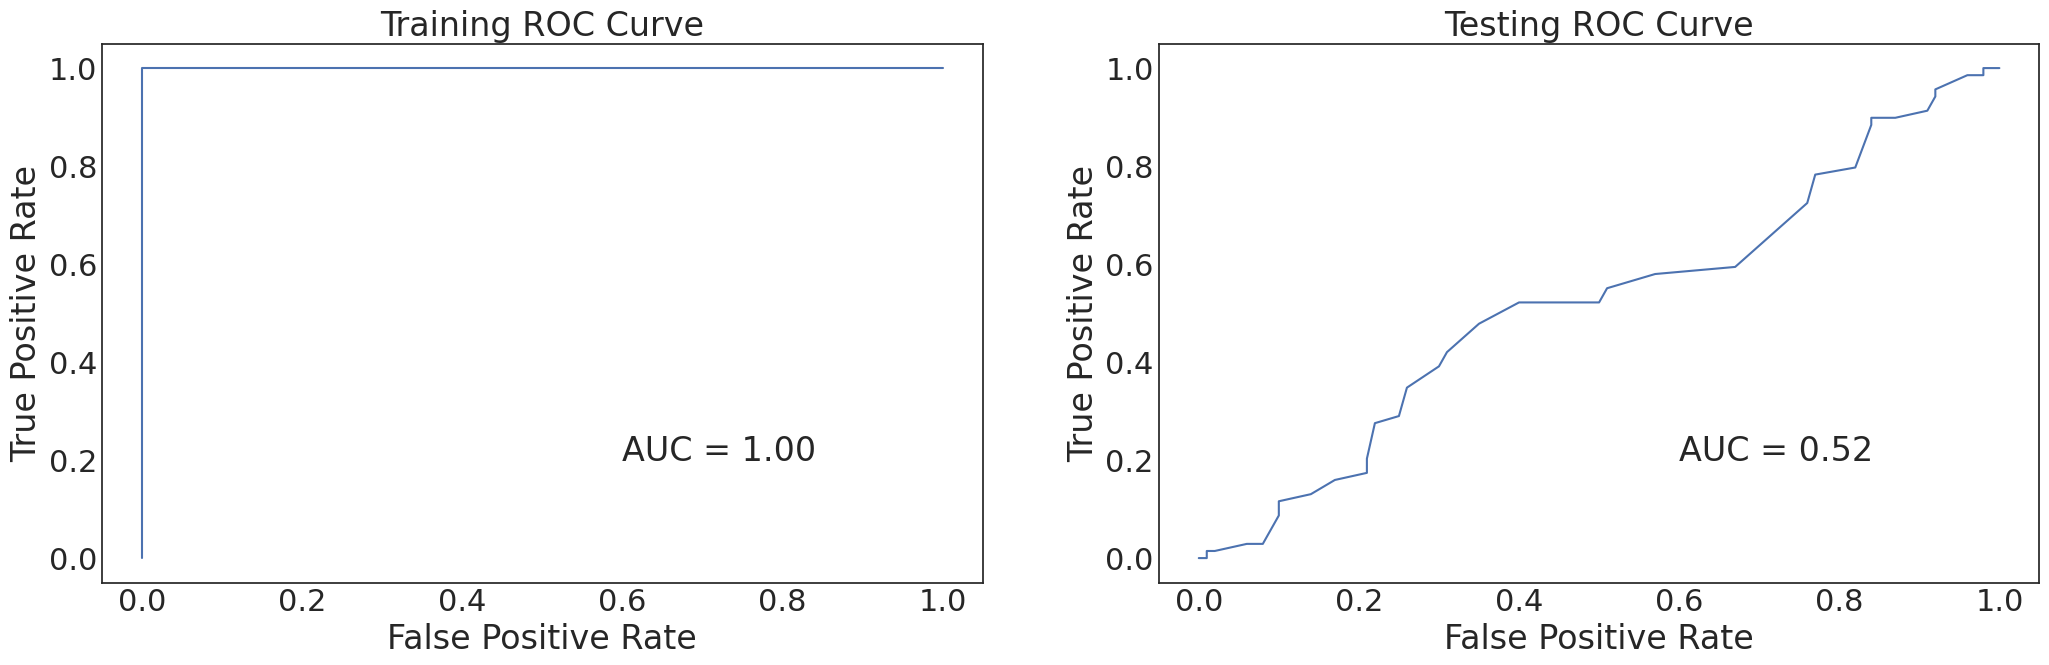

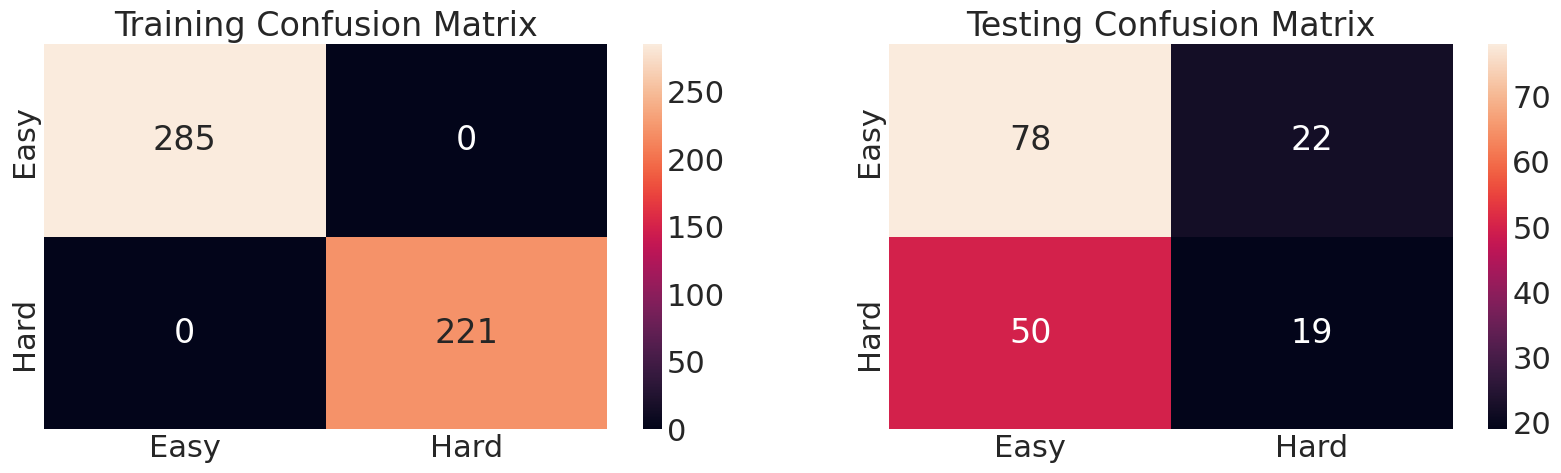

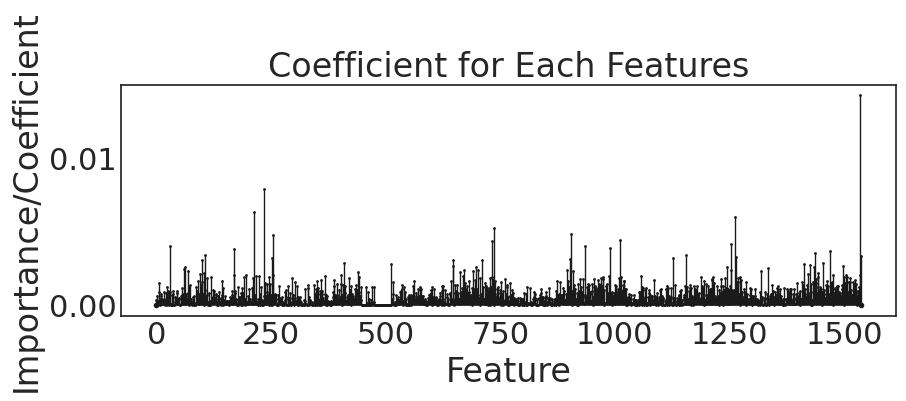

In [21]:
# Trial Difficulty Classification - Raw EEG 
test_pred_raw, train_pred_raw, train_acc_raw, test_acc_raw, coefs_raw = spoken_difficulty_classification(raw_train_norm, raw_test_norm,y_train_raw, y_test_raw, 'random_forest', 'raw')

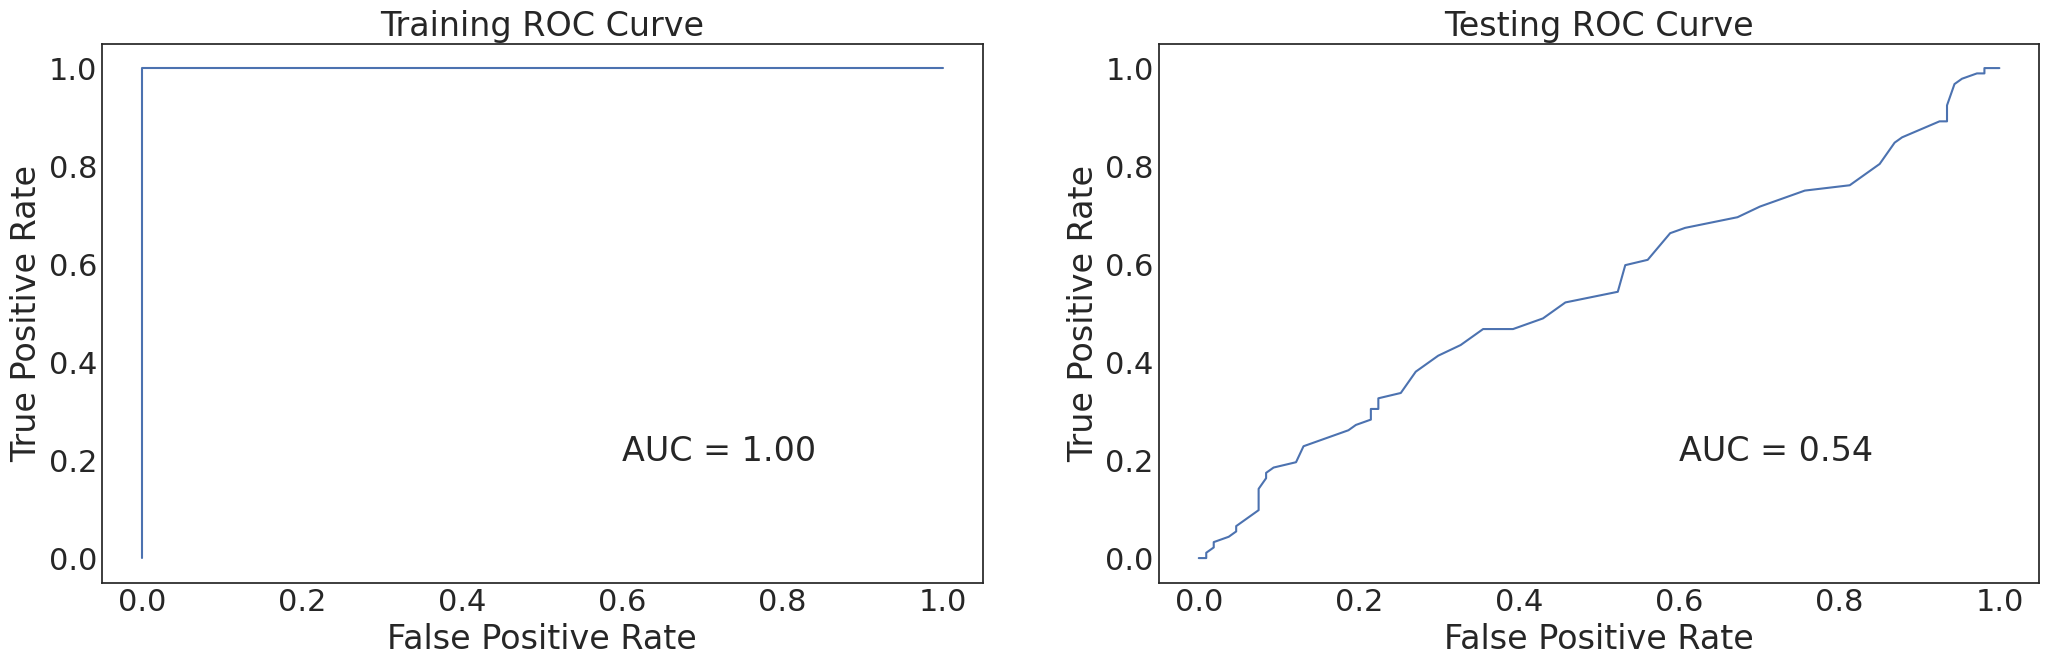

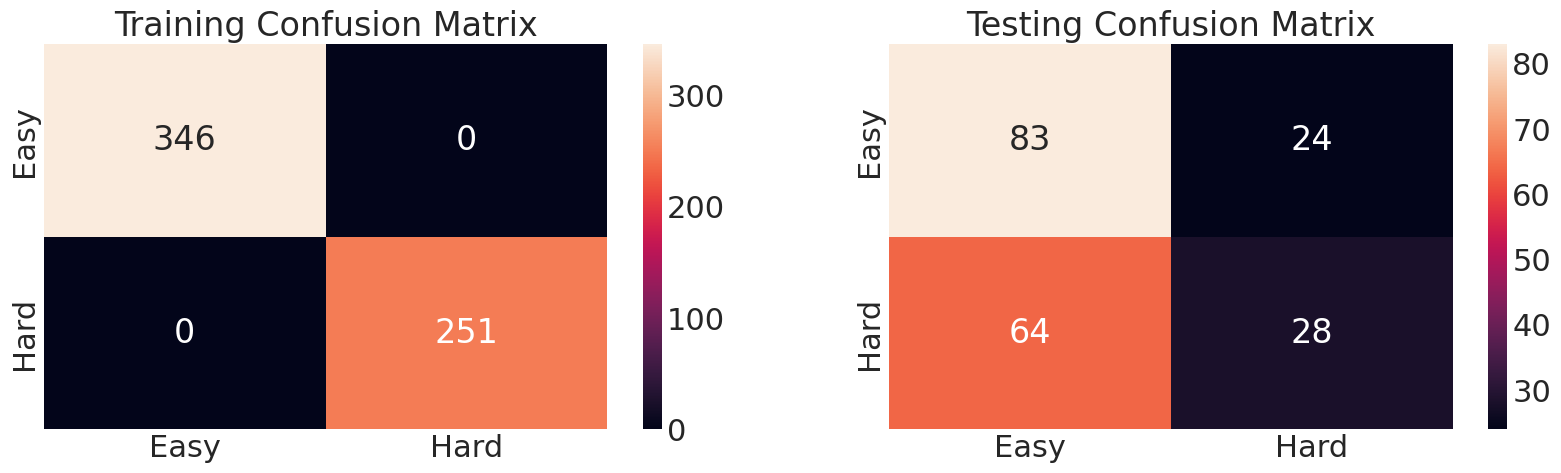

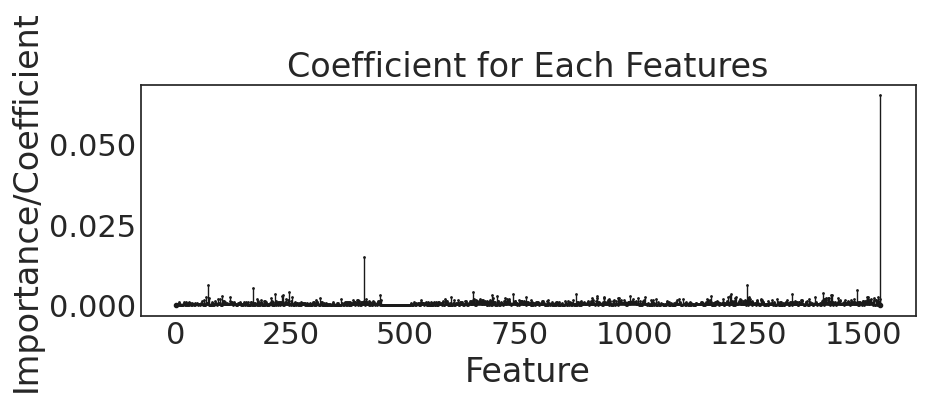

In [22]:
# Trial Difficulty Classification - Artifacts Removed EEG

test_pred_proc, train_pred_proc, train_acc_proc, test_acc_proc, coefs_proc = spoken_difficulty_classification(proc_train_norm, proc_test_norm,y_train_proc, y_test_proc, 'random_forest', 'processed')

# print(f"Training Accuracy with Artifacts Removal: {train_acc_proc:.2f} \n"
#       f"Training Label:      {y_train_proc} \n"
#       f"Training Prediction: {train_pred_proc} \n"
#       f"Test Accuracy with Artifacts Removal: {test_acc_proc:.2f} \n"
#       f"Test Label:      {y_test_proc} \n"
#       f"Test Prediction: {test_pred_proc}")

In [20]:
# Generate table for feature importance

# features_list = list(processed_selected_channel_bp.columns)
features_list = list(processed_eeg_features.columns)
features_list.extend(["Left Pupil Diameter","Right Pupil Diameter"])

bottom_10_raw = np.argsort(coefs_raw)[:10]
bottom_10_raw_features = [features_list[i] for i in bottom_10_raw]
top_10_raw = np.argsort(coefs_raw)[-10:]
top_10_raw_features = [features_list[i] for i in top_10_raw]


bottom_10_proc = np.argsort(coefs_proc)[:10]
bottom_10_proc_features = [features_list[i] for i in bottom_10_proc]
top_10_proc = np.argsort(coefs_proc)[-10:]
top_10_proc_features = [features_list[i] for i in top_10_proc]

features_ranking = {
    'Top 10 features for raw filtered data': top_10_raw_features,
    'Bottom 10 features for raw filtered data': bottom_10_raw_features,
    'Top 10 features for ICA processed raw filtered data': top_10_proc_features,
    'Bottom 10 features for ICA processed raw filtered data': bottom_10_proc_features
}

df_features = pd.DataFrame(features_ranking)
df_features.to_excel(f"{output_dir}saved_files/ranked_features_all.xlsx")
# df_features.to_csv(f"{output_dir}saved_files/ranked_features_all.csv")

# print (len(top_10_raw_features),len(bottom_10_raw_features), len(top_10_proc_features), len(bottom_10_proc_features))

In [1]:
features_list[bottom_10_raw]

NameError: name 'features_list' is not defined

## ICA-Adaptive Filter - WIP

In [ ]:
# !pip install EMD_signal
import PyEMD
from PyEMD import EMD, Visualisation

# eeg_comps = ica.get_sources(raw).get_data() #eeg componenets for all epochs
# # eeg_comps = ica.get_sources(epochs).get_data() #eeg componenets for all epochs
# # comps_epoch_concat = np.empty([eeg_comps.shape[1],eeg_comps.shape[2]*eeg_comps.shape[0]]) #initiate empty array
# # for i in range(eeg_comps.shape[0]):
# #     comps_epoch_concat[:,i*eeg_comps.shape[2]:eeg_comps.shape[2]*(i+1)] = eeg_comps[i]

# component_no = 5
# test_comps = eeg_comps[component_no]

# emd = EMD() # EMD instantiation
# emd.emd(test_comps) # decompose signal into IMFs and residue
# imfs, res = emd.get_imfs_and_residue()

# # # imfs = emd(np.squeeze(eeg_comps[0])[0])

In [ ]:
# scipy.stats.kurtosis(test_comps)

In [ ]:
# # Visualization
# t = np.arange(0, 3+1/freq, 1/freq)
# vis = Visualisation()
# vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
# # vis.plot_instant_freq(t, imfs=imfs)
# vis.show()